# AutoTrader Challenge

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pyarrow # For accessing parquet files
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, max_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

In [2]:
data_path= f"rate_of_sale_may_2023.snappy.parquet" 

data_dict_path = f"rate_of_sale_data_dict.csv" 

df = pd.read_parquet(data_path) 

category_descriptions = pd.read_csv(data_dict_path) 

In [3]:
df.head(10)

,stock_item_id,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,...,odometer_reading_miles,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality,postcode_area
0,52ae009b671ab58b3d4ff109a9fbdcf8d847de0fa190e1...,2023-05-05,2021-03-25,771,6995,6495.0,False,3.9,Independent,5.0,...,65000,2004-05-07,*IMMACULATE**FULL HISTORY*,False,NOANALYSIS,NaN,NaN,50,NaN,AL
1,32b1bac6934b1f64ff43cffa9df5aa296ead8143c36f9f...,2023-05-09,2021-05-25,714,13725,14995.0,False,NaN,Franchise,5.0,...,16018,2019-11-30,Sports Styling | Great Economy,True,GOOD,14848.0,26078.0,15,57.0,HP
2,21703d22d87eaa95c4dc81a60ba2c8cbe3b90ab659292c...,2023-05-12,2021-11-26,532,15499,13999.0,False,0.2,Independent,5.0,...,31093,2018-03-08,"Sat Nav,Leather,Auto,Euro 6",False,GREAT,14571.0,34732.0,22,61.0,SR
3,661acafc271373946cea7d30ac7f34257404ab89a1ad33...,2023-05-16,2022-02-17,453,10995,9995.0,False,7.9,Franchise,5.0,...,79000,2015-07-02,Viewing by APPOINTMENT ONLY,False,FAIR,9349.0,65684.0,30,61.0,FY
4,638216dc92410d965b416fea5b3cec9ca903368795fdde...,2023-05-04,2022-03-21,409,46000,37500.0,False,6.8,Franchise,5.0,...,10214,2022-03-03,Reserve Online,True,GOOD,37055.0,11765.0,22,48.0,LE
5,e3c8b08856a8736bb48c38f083d42f43f3e3e8e3466610...,2023-05-21,2022-04-27,389,1395,1295.0,False,2.6,Independent,5.0,...,91000,2009-03-25,8 MONTHS MOT,False,NOANALYSIS,2285.0,61512.0,15,NaN,RG
6,82369d8013f2ab13f8f49fb780797298a8dd19974d3b60...,2023-05-14,2022-06-06,342,8257,7457.0,False,NaN,Independent,5.0,...,58849,2015-03-18,"£0 ROAD TAX, 1/2 LEATHER SEATS",False,LOW,8145.0,52450.0,24,54.0,PE
7,1fd13f137d7ed19e993b07dd1708992582537e56efb863...,2023-05-03,2022-06-16,321,23500,19500.0,False,1.2,Independent,5.0,...,40000,2017-11-30,LOW MILEAGE AUTOMATIC,False,NOANALYSIS,24662.0,52255.0,23,44.0,N
8,c34a29671d55abf60ea1ab1c23ad21a0a7437c8ffea756...,2023-05-16,2022-06-23,327,96950,84950.0,False,NaN,Independent,4.0,...,5000,2018-03-29,Mulliner Driving Specification,False,NOANALYSIS,96290.0,23167.0,9,NaN,HP
9,db6f342f73f5c7819fef4254e6886387eac15e026878ab...,2023-05-22,2022-06-24,332,15995,15695.0,False,NaN,Independent,5.0,...,34000,2018-11-07,DEPOSIT TAKEN ON THIS CAR,False,GOOD,15973.0,37233.0,30,65.0,CO


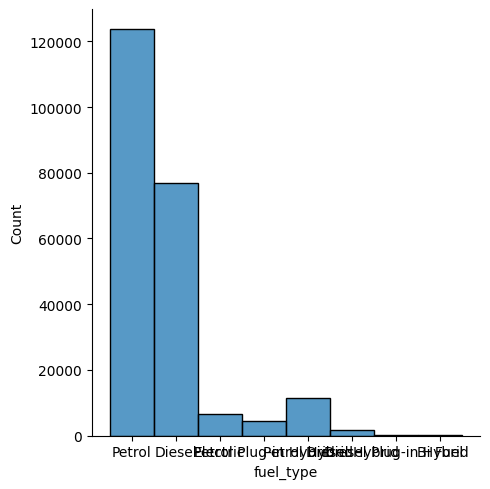

In [4]:
sns.displot(data=df, x='fuel_type')

## Data Sanitisation

### Drop Irrelevant Columns

In [5]:
df = df.drop(columns=['stock_item_id', 'last_date_seen', 'attention_grabber', 'derivative', 'generation', 'derivative_id'])

### Categorical Null Records

In [6]:
length = len(df)
discrete_cols = ['can_home_deliver', 
                    'segment', 
                    'seats', 
                    'doors', 
                    'insurance_group', 
                    'plate', 
                    'make', 
                    'model', 
                    'body_type', 
                    'fuel_type', 
                    'transmission_type', 
                    'drivetrain', 
                    'colour', 
                    'manufacturer_approved', 
                    'price_indicator_rating']

In [7]:
for col in discrete_cols:
    df = df.dropna(subset=[col])
    print(f'{str(length - len(df))} NULL records dropped: ' + col)
    length = len(df)

0 NULL records dropped: can_home_deliver
32 NULL records dropped: segment
129 NULL records dropped: seats
3 NULL records dropped: doors
613 NULL records dropped: insurance_group
4 NULL records dropped: plate
0 NULL records dropped: make
0 NULL records dropped: model
0 NULL records dropped: body_type
0 NULL records dropped: fuel_type
0 NULL records dropped: transmission_type
0 NULL records dropped: drivetrain
2027 NULL records dropped: colour
0 NULL records dropped: manufacturer_approved
0 NULL records dropped: price_indicator_rating


### Continuous Null Records

In [8]:
length = len(df)
cont_cols = ["first_retailer_asking_price", 
             "last_retailer_asking_price", 
             "reviews_per_100_advertised_stock_last_12_months", 
             "co2_emission_gpkm", 
             "top_speed_mph", 
             "engine_power_bhp",
             "fuel_economy_wltp_combined_mpg",
             "advert_quality",
             "number_of_images",
             "predicted_mileage",
             "adjusted_retail_amount_gbp",
             "first_registration_date",
             "odometer_reading_miles",
             "boot_space_seats_up_litres",
             "length_mm"]

In [9]:
for col in cont_cols:
    df = df.dropna(subset=[col])
    print(f'{str(length - len(df))} NULL records dropped: ' + col)
    length = len(df)

0 NULL records dropped: first_retailer_asking_price
914 NULL records dropped: last_retailer_asking_price
32749 NULL records dropped: reviews_per_100_advertised_stock_last_12_months
10 NULL records dropped: co2_emission_gpkm
347 NULL records dropped: top_speed_mph
0 NULL records dropped: engine_power_bhp
5156 NULL records dropped: fuel_economy_wltp_combined_mpg
34199 NULL records dropped: advert_quality
0 NULL records dropped: number_of_images
4654 NULL records dropped: predicted_mileage
686 NULL records dropped: adjusted_retail_amount_gbp
0 NULL records dropped: first_registration_date
0 NULL records dropped: odometer_reading_miles
2381 NULL records dropped: boot_space_seats_up_litres
2 NULL records dropped: length_mm


In [10]:
len(df)

140649

In [11]:
df.describe()

,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,reviews_per_100_advertised_stock_last_12_months,seats,doors,co2_emission_gpkm,top_speed_mph,battery_range_miles,boot_space_seats_up_litres,odometer_reading_miles,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality
count,140649.000000,140649.000000,1.406490e+05,140649.000000,140649.000000,140649.000000,140649.000000,140649.000000,3167.000000,140649.000000,140649.000000,140649.000000,140649.000000,140649.000000,140649.000000
mean,40.487782,17884.312039,1.751741e+04,9.007578,4.955556,4.620168,133.220506,123.884073,57.430376,378.156361,43644.631402,17689.173972,43968.198679,34.831659,54.814048
std,47.527803,13696.755266,1.866730e+04,11.542546,0.642084,0.838509,34.291037,16.462364,70.363918,166.485043,30844.097202,12943.341947,26061.228247,17.827567,15.031841
min,1.000000,1.000000,1.000000e+00,0.000000,2.000000,2.000000,0.000000,0.000000,15.000000,0.000000,0.000000,349.000000,0.000000,0.000000,1.000000
25%,12.000000,9795.000000,9.600000e+03,1.400000,5.000000,5.000000,114.000000,112.000000,28.000000,290.000000,19643.000000,9720.000000,23868.000000,22.000000,46.000000
50%,27.000000,15430.000000,1.500000e+04,5.100000,5.000000,5.000000,129.000000,122.000000,33.000000,380.000000,37626.000000,15316.000000,39076.000000,32.000000,56.000000
75%,53.000000,22000.000000,2.169500e+04,12.600000,5.000000,5.000000,149.000000,134.000000,40.000000,480.000000,62000.000000,21898.000000,61615.000000,43.000000,65.000000
max,1431.000000,898100.000000,4.999995e+06,300.000000,8.000000,6.000000,396.000000,248.000000,414.000000,1900.000000,901128.000000,233997.000000,154388.000000,193.000000,100.000000


<Axes: ylabel='co2_emission_gpkm'>

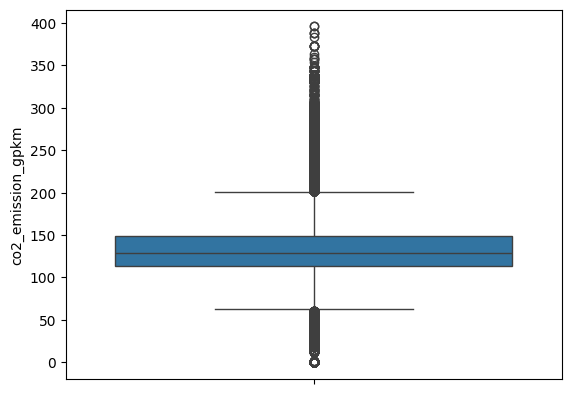

In [12]:
sns.boxplot(df["co2_emission_gpkm"])

In [13]:
new_df = df

lq = 0.25
uq = 0.75

for col in cont_cols:
    if col == "advert_quality": # no outliers in a 0-100 percentage, so skip
        continue

    print("Removing outliers from '" + col + "' column")

    if("date" not in col):
        new_df[col] = new_df[col].astype('float')
    # calculate IQR for column Height
    q1 = new_df[col].quantile(lq)
    q3 = new_df[col].quantile(uq)
    iqr = q3 - q1

    # identify outliers
    threshold = 1.5
    outliers = new_df[(new_df[col] < q1 - threshold * iqr) | (new_df[col] > q3 + threshold * iqr)]

    new_df = new_df.drop(outliers.index)
    print(f"Removed {len(outliers)} outliers from df")
    

Removing outliers from 'first_retailer_asking_price' column
Removed 6145 outliers from df
Removing outliers from 'last_retailer_asking_price' column
Removed 1349 outliers from df
Removing outliers from 'reviews_per_100_advertised_stock_last_12_months' column
Removed 8338 outliers from df
Removing outliers from 'co2_emission_gpkm' column
Removed 5140 outliers from df
Removing outliers from 'top_speed_mph' column
Removed 284 outliers from df
Removing outliers from 'engine_power_bhp' column
Removed 5885 outliers from df
Removing outliers from 'fuel_economy_wltp_combined_mpg' column
Removed 1874 outliers from df
Removing outliers from 'number_of_images' column
Removed 2715 outliers from df
Removing outliers from 'predicted_mileage' column
Removed 512 outliers from df
Removing outliers from 'adjusted_retail_amount_gbp' column
Removed 838 outliers from df
Removing outliers from 'first_registration_date' column
Removed 0 outliers from df
Removing outliers from 'odometer_reading_miles' column


<Axes: ylabel='number_of_images'>

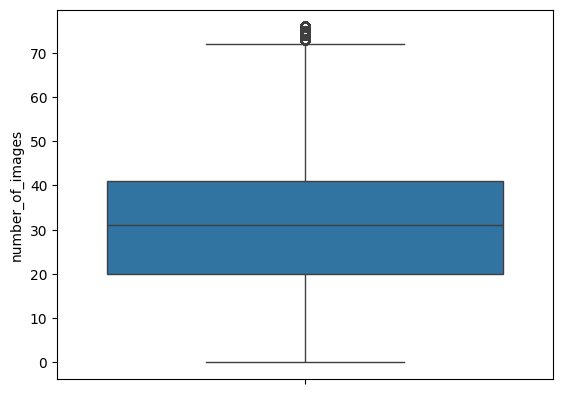

In [14]:
sns.boxplot(new_df["number_of_images"])

In [15]:
df = new_df

In [16]:
discrete_cols = ['first_date_seen',
                 'can_home_deliver',
                 'segment',
                 'insurance_group',
                 'plate',
                 'make',
                 'model',
                 'body_type',
                 'fuel_type',
                 'transmission_type',
                 'drivetrain',
                 'colour',
                 'first_registration_date',
                 'manufacturer_approved',
                 'price_indicator_rating',
                 'postcode_area']

label_encoder = LabelEncoder()


In [17]:
for col in discrete_cols:
    df[col] = label_encoder.fit_transform(df[col])

## Model

In [18]:
X = df.drop(columns=['days_to_sell'])
y = df['days_to_sell']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0,
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73124, 35), (73124,), (24375, 35), (24375,))

In [20]:
rfr = RandomForestRegressor(n_estimators=250)

In [21]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=250)

In [22]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [23]:
rfr.score(X_test, y_test)

0.972943439836824

### Model Optimisation

In [24]:
np.random.seed(280202)

param_distributions = {"max_depth": [3, None],
                       "min_samples_split": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                       "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                    }

search = HalvingRandomSearchCV(rfr, param_distributions, 
                               resource="n_estimators",
                               n_candidates='exhaust',
                               factor=2,
                               aggressive_elimination=True,
                               max_resources=300, 
                               random_state=280202, 
                               scoring='r2', 
                               n_jobs=-2)

In [25]:
search = search.fit(X_train, y_train)


c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python311\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_

In [26]:
search.score(X_train, y_train)

0.9828835814933493

In [27]:
search.score(X_test, y_test)

0.9732063267831096

In [28]:
search.best_params_

{'min_samples_split': 12,
 'min_samples_leaf': 10,
 'max_depth': None,
 'n_estimators': 256}